In [55]:
# czy przy takim samym rozmiarze zdjęcia wejściowego na lepszym modelu będzie lepsze accuraycy?
# czy przy mniejszym batch_size i bardziej skomplikowanym modelu model będzie w stanie się nauczyć na dobry poziom? może Batch size jest kluczowe?

In [56]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [57]:
import pathlib
data_dir = "images"
data_dir = pathlib.Path(data_dir)

In [58]:
data_dir

WindowsPath('images')

In [59]:
batch_size = 6 #32
img_height = int(3888*0.3)
img_width = int(5184*0.3)

In [60]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 765 files belonging to 5 classes.
Using 459 files for training.


In [61]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 765 files belonging to 5 classes.
Using 306 files for validation.


In [62]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

In [63]:
class_names = train_ds.class_names
print(class_names)

['brown_rust', 'healthy', 'rhynhosporium', 'septoria', 'yellow_rust']


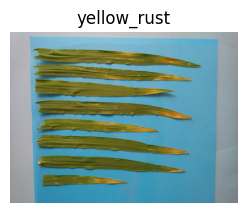

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [65]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(6, 1166, 1555, 3)
(6,)


In [66]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [67]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8743234


In [68]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [69]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  # tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [70]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [71]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=7,
)

Epoch 1/7
77/77 [==============================] - 821s 10s/step - loss: 0.9607 - accuracy: 0.6449 - val_loss: 0.6861 - val_accuracy: 0.7941
Epoch 2/7
77/77 [==============================] - 710s 9s/step - loss: 0.3042 - accuracy: 0.9085 - val_loss: 0.4903 - val_accuracy: 0.8529
Epoch 3/7
77/77 [==============================] - 714s 9s/step - loss: 0.1794 - accuracy: 0.9521 - val_loss: 0.3814 - val_accuracy: 0.8333
Epoch 4/7
77/77 [==============================] - 711s 9s/step - loss: 0.0470 - accuracy: 0.9869 - val_loss: 0.6154 - val_accuracy: 0.8431
Epoch 5/7
77/77 [==============================] - 715s 9s/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.2287 - val_accuracy: 0.9412
Epoch 6/7
77/77 [==============================] - 706s 9s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.5167 - val_accuracy: 0.9216
Epoch 7/7
30/77 [==========>...................] - ETA: 7:12 - loss: 0.0019 - accuracy: 1.0000

KeyboardInterrupt: 

In [72]:
# batch size 4 - sieć się w ogóle nie uczytał

# batch_size = 4 #32
# img_height = int(3888*0.25)
# img_width = int(5184*0.25)
# Epoch 1/5
# 153/153 [==============================] - 687s 4s/step - loss: 2.7020 - accuracy: 0.5000 - val_loss: 0.7917 - val_accuracy: 0.7255
# Epoch 2/5
# 153/153 [==============================] - 638s 4s/step - loss: 0.6519 - accuracy: 0.8056 - val_loss: 0.7390 - val_accuracy: 0.7320
# Epoch 3/5
# 153/153 [==============================] - 657s 4s/step - loss: 0.2615 - accuracy: 0.9281 - val_loss: 1.2718 - val_accuracy: 0.6340
# Epoch 4/5
# 153/153 [==============================] - 640s 4s/step - loss: 0.2231 - accuracy: 0.9510 - val_loss: 0.5995 - val_accuracy: 0.8497
# Epoch 5/5
# 153/153 [==============================] - 643s 4s/step - loss: 0.1121 - accuracy: 0.9722 - val_loss: 0.6025 - val_accuracy: 0.8431
# <keras.callbacks.History at 0x267aec56640>

In [73]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

765


In [74]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [75]:
for f in list_ds.take(5):
    print(f.numpy())

b'images\\septoria\\20210706_184040.jpg'
b'images\\yellow_rust\\DSCN2373.JPG'
b'images\\brown_rust\\20210608_165509.jpg'
b'images\\septoria\\20210706_191211.jpg'
b'images\\yellow_rust\\20210602_170402.jpg'


In [76]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['brown_rust' 'healthy' 'rhynhosporium' 'septoria' 'yellow_rust']


In [77]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [78]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

612
153


In [79]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [80]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [81]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [82]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [83]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (1166, 1555, 3)
Label:  4


In [84]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

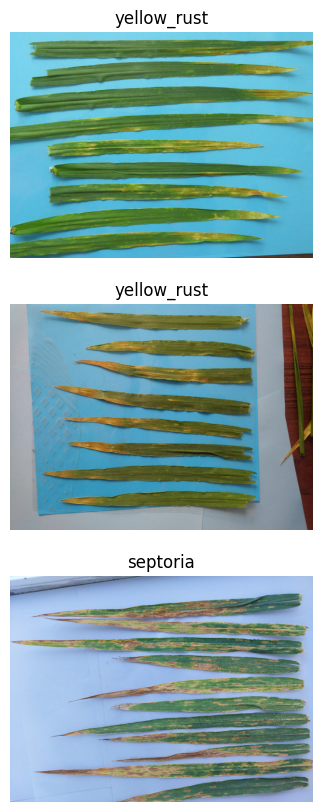

In [85]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i] 
    plt.title(class_names[label])
    plt.axis("off")

In [86]:
# model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=3
# )

1/1 [==============================] - 5s 5s/step


(-0.5, 1554.5, 1165.5, -0.5)

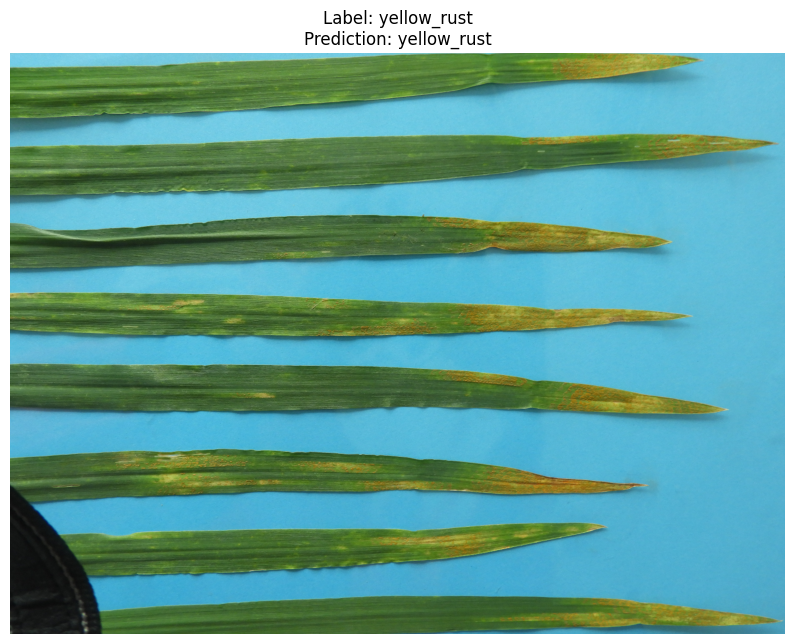

In [87]:
import random
image_batch, label_batch = next(iter(train_ds))
rand = random.choice(range(batch_size))
rand


plt.figure(figsize=(10, 10))

plt.imshow(image_batch[rand].numpy().astype("uint8"))
label = label_batch[rand]
prediction = class_names[np.argmax(model.predict(image_batch)[rand])]
plt.title("Label: " + class_names[label] + "\n" + "Prediction: " + prediction)
plt.axis("off")

1/1 [==============================] - 6s 6s/step


(-0.5, 1554.5, 1165.5, -0.5)

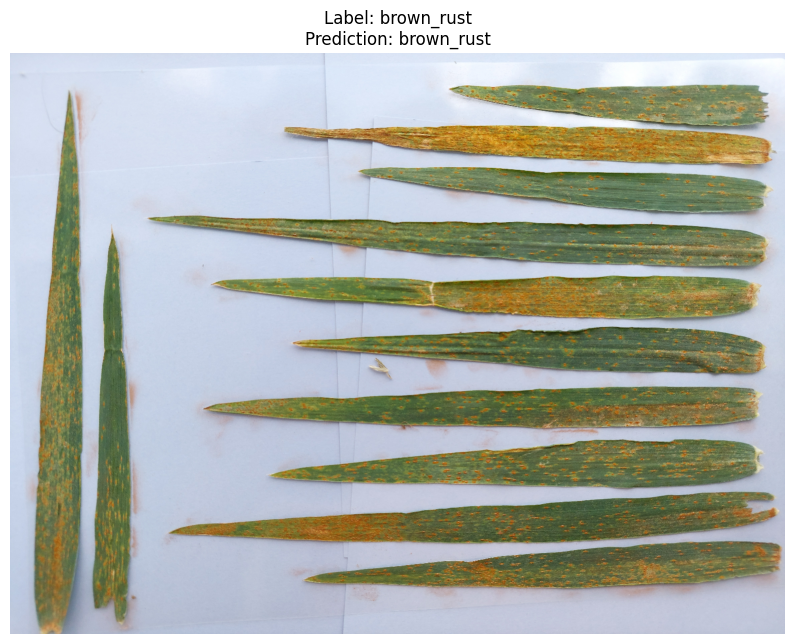

In [88]:
import random
image_batch, label_batch = next(iter(val_ds))
rand = random.choice(range(batch_size))
rand


plt.figure(figsize=(10, 10))

plt.imshow(image_batch[rand].numpy().astype("uint8"))
label = label_batch[rand]
prediction = class_names[np.argmax(model.predict(image_batch)[rand])]
plt.title("Label: " + class_names[label] + "\n" + "Prediction: " + prediction)
plt.axis("off")

1/1 [==============================] - 1s 1s/step


(-0.5, 1554.5, 1165.5, -0.5)

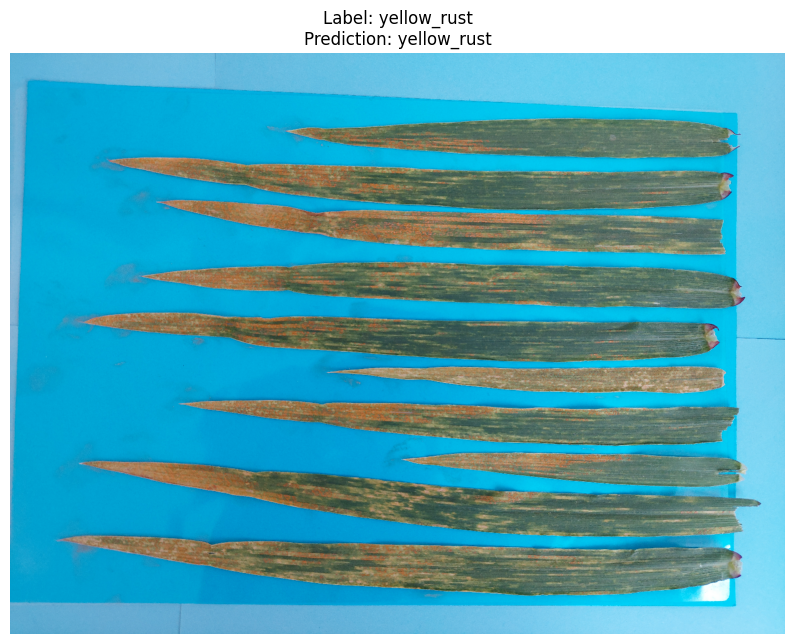

In [101]:
import random
image_batch, label_batch = next(iter(test_ds))
rand = random.choice(range(batch_size))
rand


plt.figure(figsize=(10, 10))

plt.imshow(image_batch[rand].numpy().astype("uint8"))
label = label_batch[rand]
prediction = class_names[np.argmax(model.predict(image_batch)[rand])]
plt.title("Label: " + class_names[label] + "\n" + "Prediction: " + prediction)
plt.axis("off")

In [90]:
# spr na testowych
model.evaluate(test_ds)

34/34 [==============================] - 71s 2s/step - loss: 0.3938 - accuracy: 0.9069


[0.39382103085517883, 0.906862735748291]

In [91]:
# spr na validacyjnych
model.evaluate(val_ds)

26/26 [==============================] - 40s 2s/step - loss: 0.0928 - accuracy: 0.9804


[0.09280071407556534, 0.9803921580314636]

In [92]:
# brudnopis

In [93]:
model.predict(image_batch)[0]

1/1 [==============================] - 2s 2s/step


array([-4.492136 , -2.7820103, -2.6620305,  3.6777754,  2.504501 ],
      dtype=float32)

In [94]:
class_names[label_batch[0]]

'septoria'

In [95]:
class_names[np.argmax(model.predict(image_batch)[0])]

1/1 [==============================] - 1s 1s/step


'septoria'

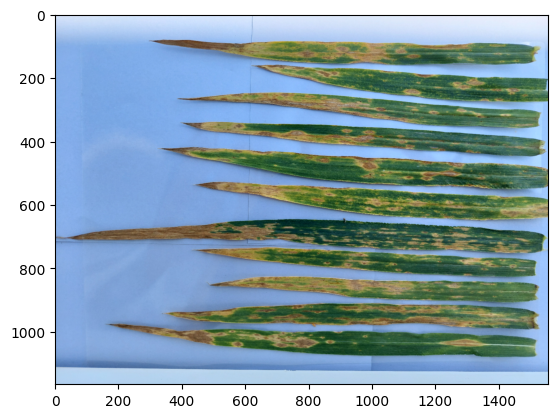

In [96]:
plt.imshow(image_batch[0].numpy().astype("uint8"))